# Marginalized Gaussian Mixture Model

Author: [Austin Rochford](http://austinrochford.com)

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns

from matplotlib import pyplot as plt

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Gaussian mixtures are a flexible class of models for data that exhibits subpopulation heterogeneity.  A toy example of such a data set is shown below.

In [3]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0.0, 2.0, 5.0])
SIGMA = np.array([0.5, 0.5, 1.0])

In [4]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

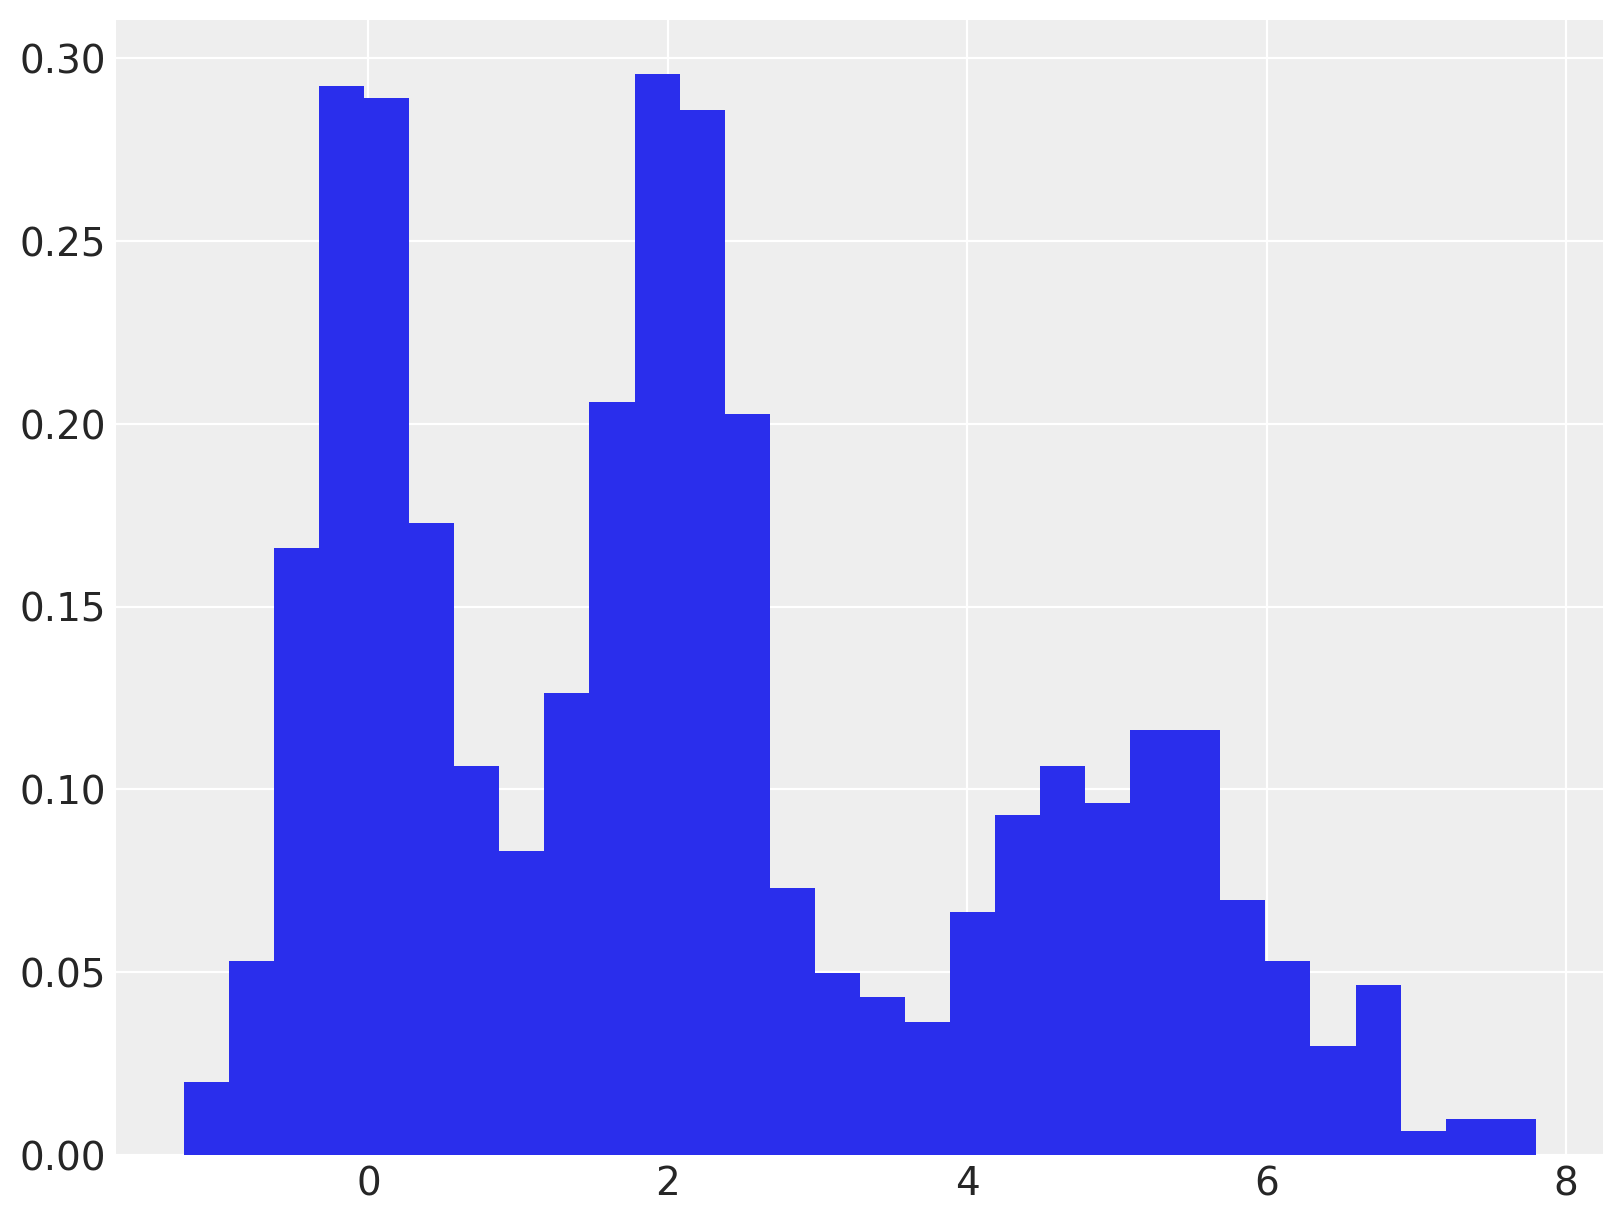

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, density=True, lw=0);

A natural parameterization of the Gaussian mixture model is as the [latent variable model](https://en.wikipedia.org/wiki/Latent_variable_model)

$$
\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\tau_1, \ldots, \tau_K
    & \sim \textrm{Gamma}(a, b) \\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
z\ |\ \boldsymbol{w}
    & \sim \textrm{Cat}(\boldsymbol{w}) \\
x\ |\ z
    & \sim N(\mu_z, \tau^{-1}_z).
\end{align*}
$$

An implementation of this parameterization in PyMC3 is available [here](https://nbviewer.jupyter.org/github/pymc-devs/pymc3/blob/master/docs/source/notebooks/gaussian_mixture_model.ipynb).  A drawback of this parameterization is that is posterior relies on sampling the discrete latent variable $z$.  This reliance can cause slow mixing and ineffective exploration of the tails of the distribution.

An alternative, equivalent parameterization that addresses these problems is to marginalize over $z$.  The marginalized model is

$$
\begin{align*}
\mu_1, \ldots, \mu_K
    & \sim N(0, \sigma^2) \\
\tau_1, \ldots, \tau_K
    & \sim \textrm{Gamma}(a, b) \\
\boldsymbol{w}
    & \sim \textrm{Dir}(\boldsymbol{\alpha}) \\
f(x\ |\ \boldsymbol{w})
    & = \sum_{i = 1}^K w_i\ N(x\ |\ \mu_i, \tau^{-1}_i),
\end{align*}
$$

where

$$N(x\ |\ \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi} \sigma} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)$$

is the probability density function of the normal distribution.

Marginalizing $z$ out of the model generally leads to faster mixing and better exploration of the tails of the posterior distribution.  Marginalization over discrete parameters is a common trick in the [Stan](http://mc-stan.org/) community, since Stan does not support sampling from discrete distributions.  For further details on marginalization and several worked examples, see the [_Stan User's Guide and Reference Manual_](http://www.uvm.edu/~bbeckage/Teaching/DataAnalysis/Manuals/stan-reference-2.8.0.pdf).

PyMC3 supports marginalized Gaussian mixture models through its `NormalMixture` class.  (It also supports marginalized general mixture models through its `Mixture` class.)  Below we specify and fit a marginalized Gaussian mixture model to this data in PyMC3.

In [6]:
with pm.Model() as model:
    w = pm.Dirichlet("w", np.ones_like(W))

    mu = pm.Normal(
        "mu",
        np.zeros_like(W),
        1.0,
        shape=W.size,
        transform=pm.transforms.ordered,
        testval=[1, 2, 3],
    )
    tau = pm.Gamma("tau", 1.0, 1.0, shape=W.size)

    x_obs = pm.NormalMixture("x_obs", w, mu, tau=tau, observed=x)

In [7]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, return_inferencedata=True)

    # sample posterior predictive samples
    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["x_obs"])

We see in the following plot that the posterior distribution on the weights and the component means has captured the true value quite well.

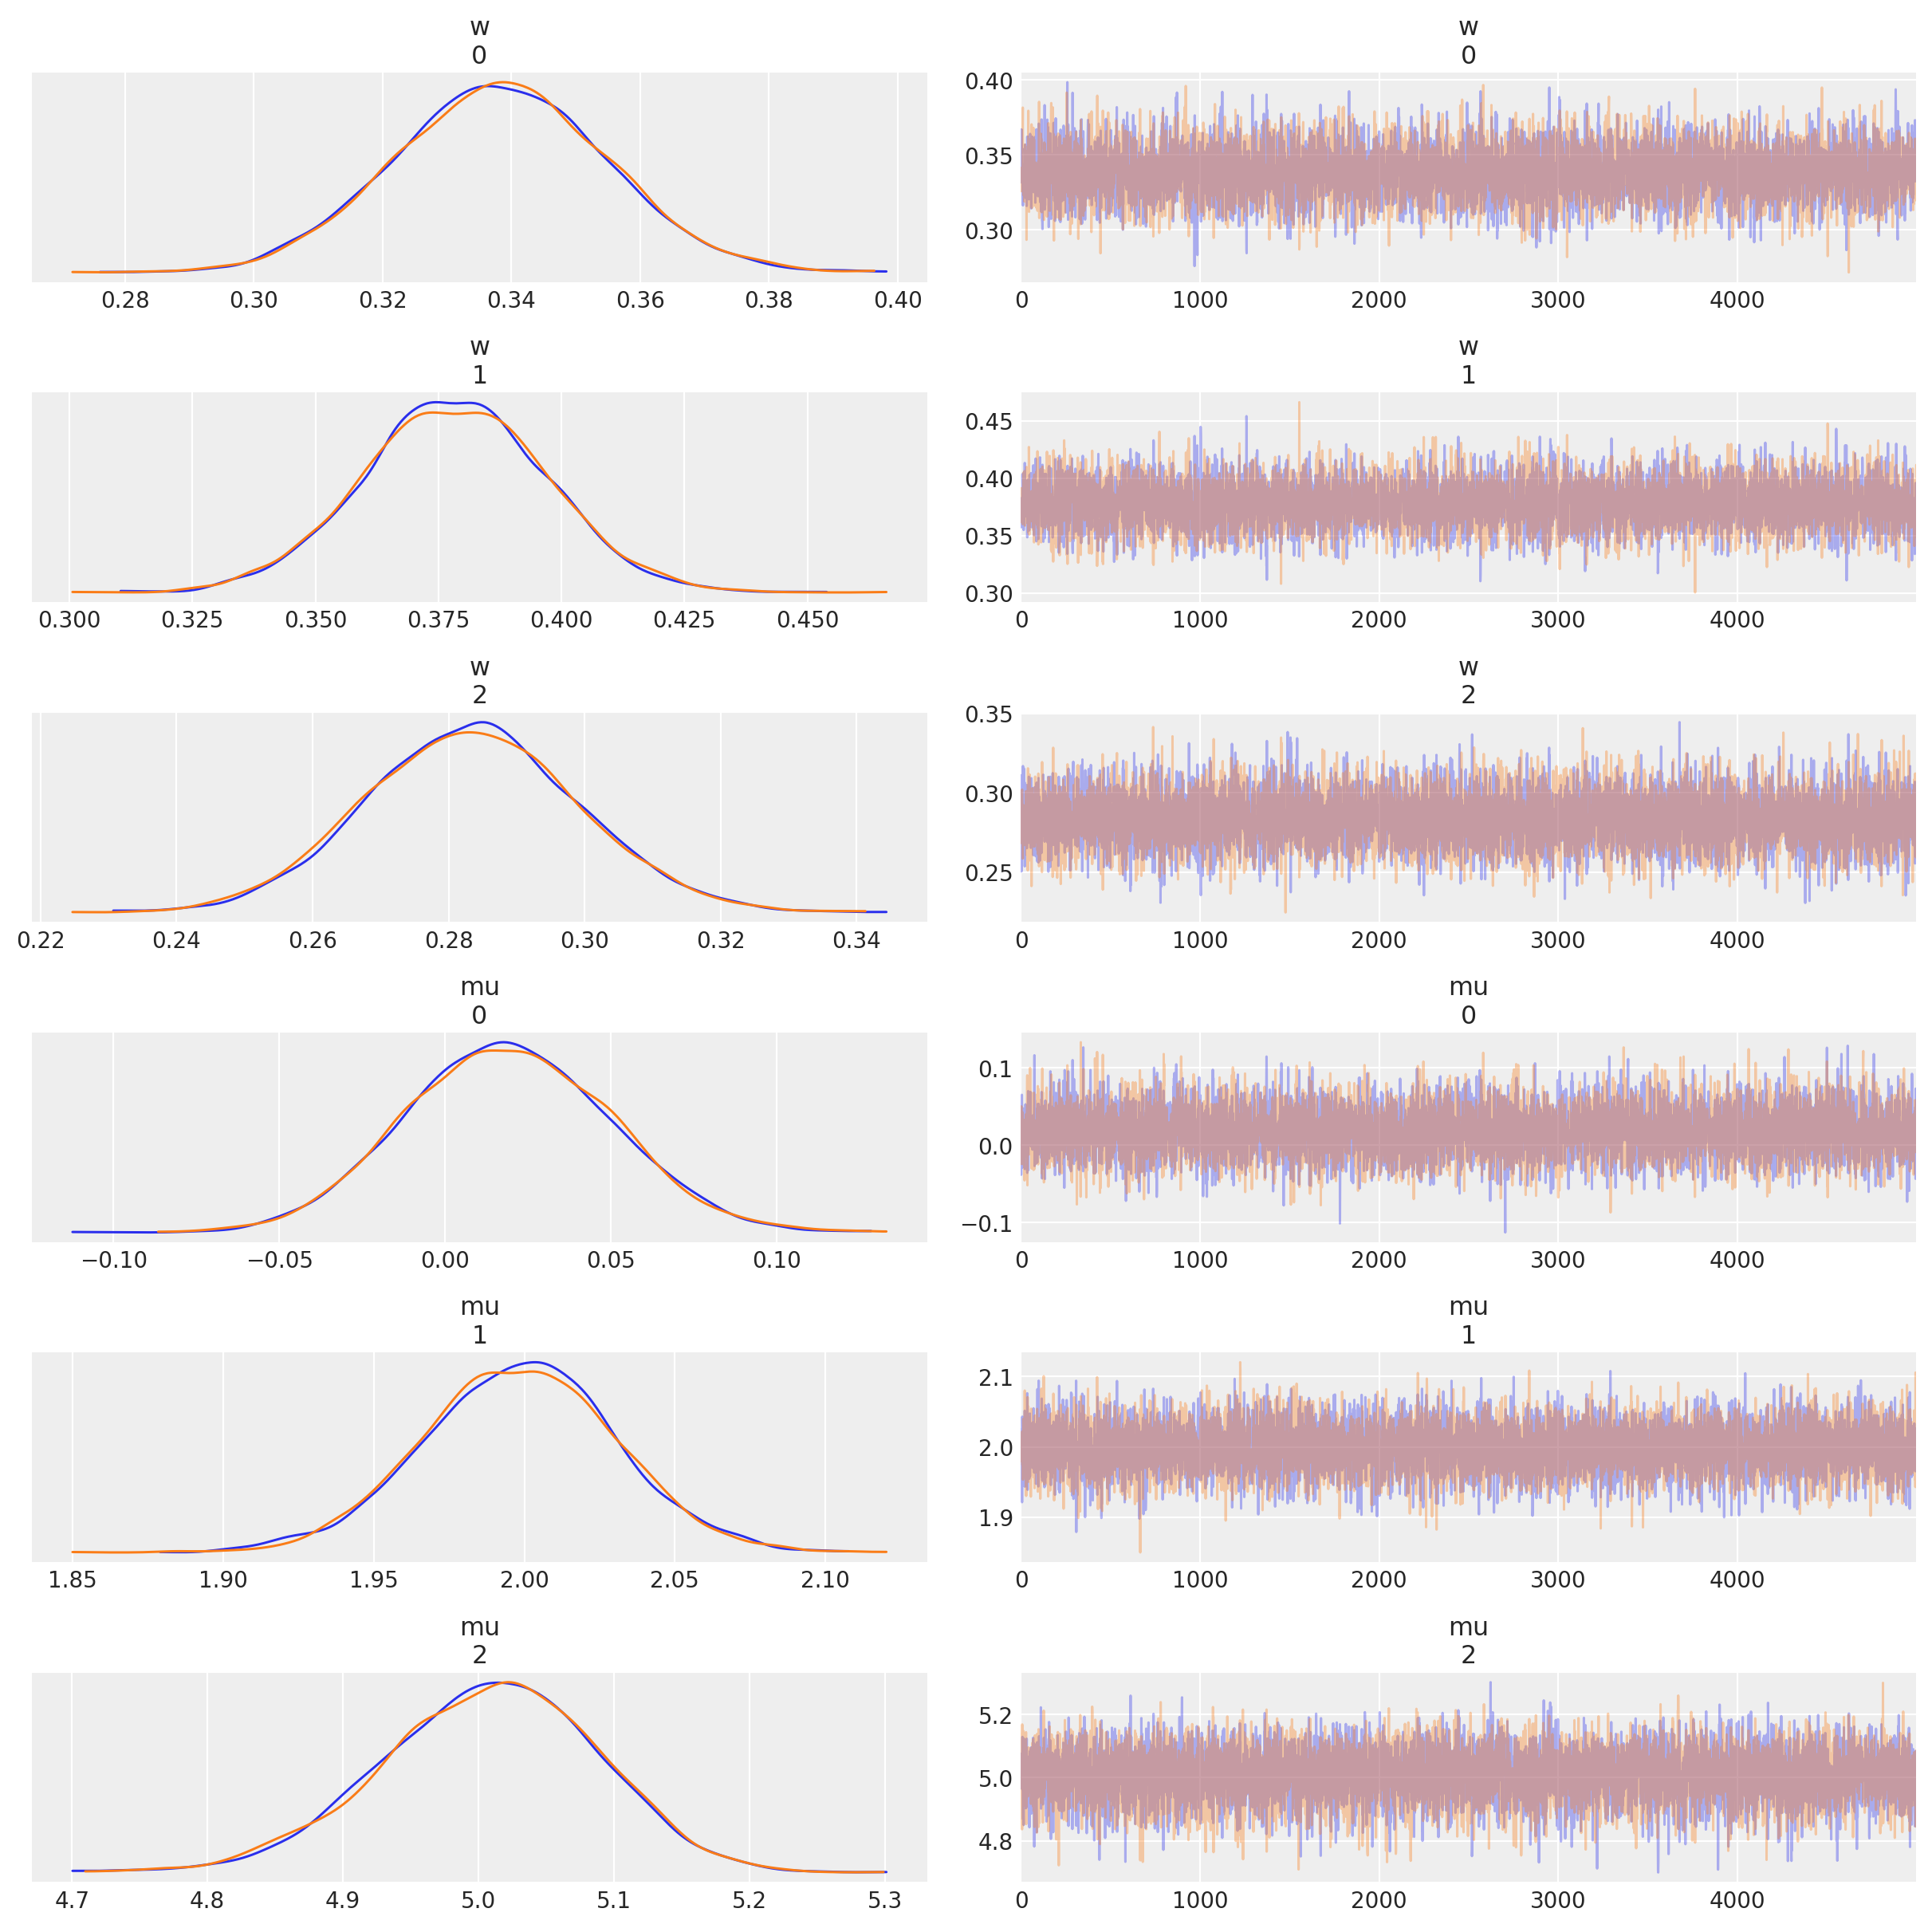

In [8]:
az.plot_trace(trace, var_names=["w", "mu"]);

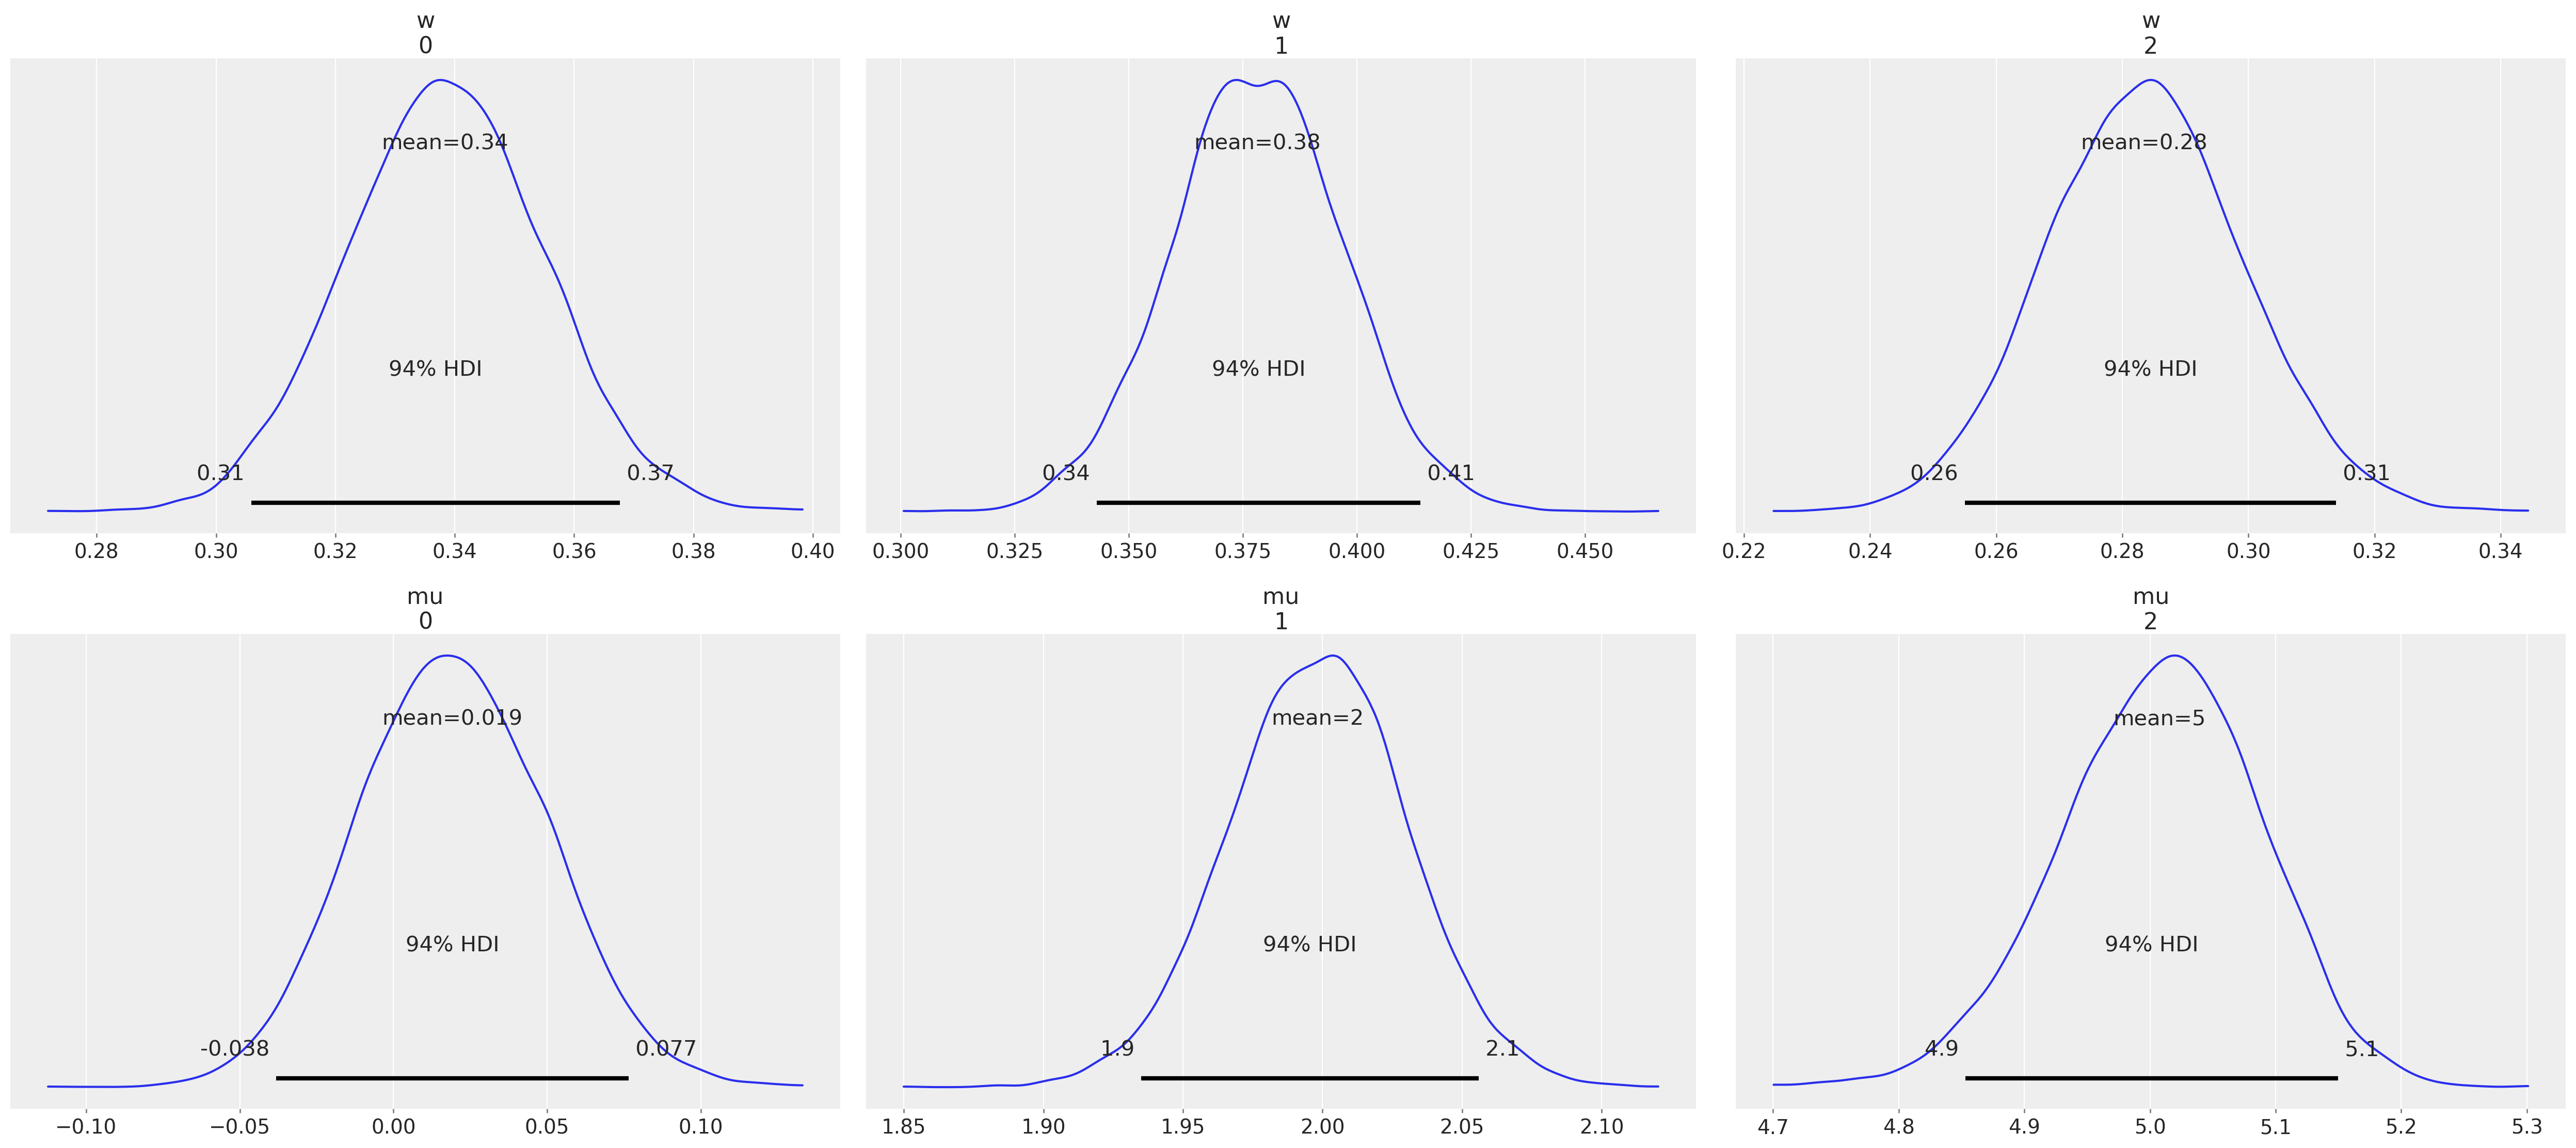

In [9]:
az.plot_posterior(trace, var_names=["w", "mu"]);

We see that the posterior predictive samples have a distribution quite close to that of the observed data.

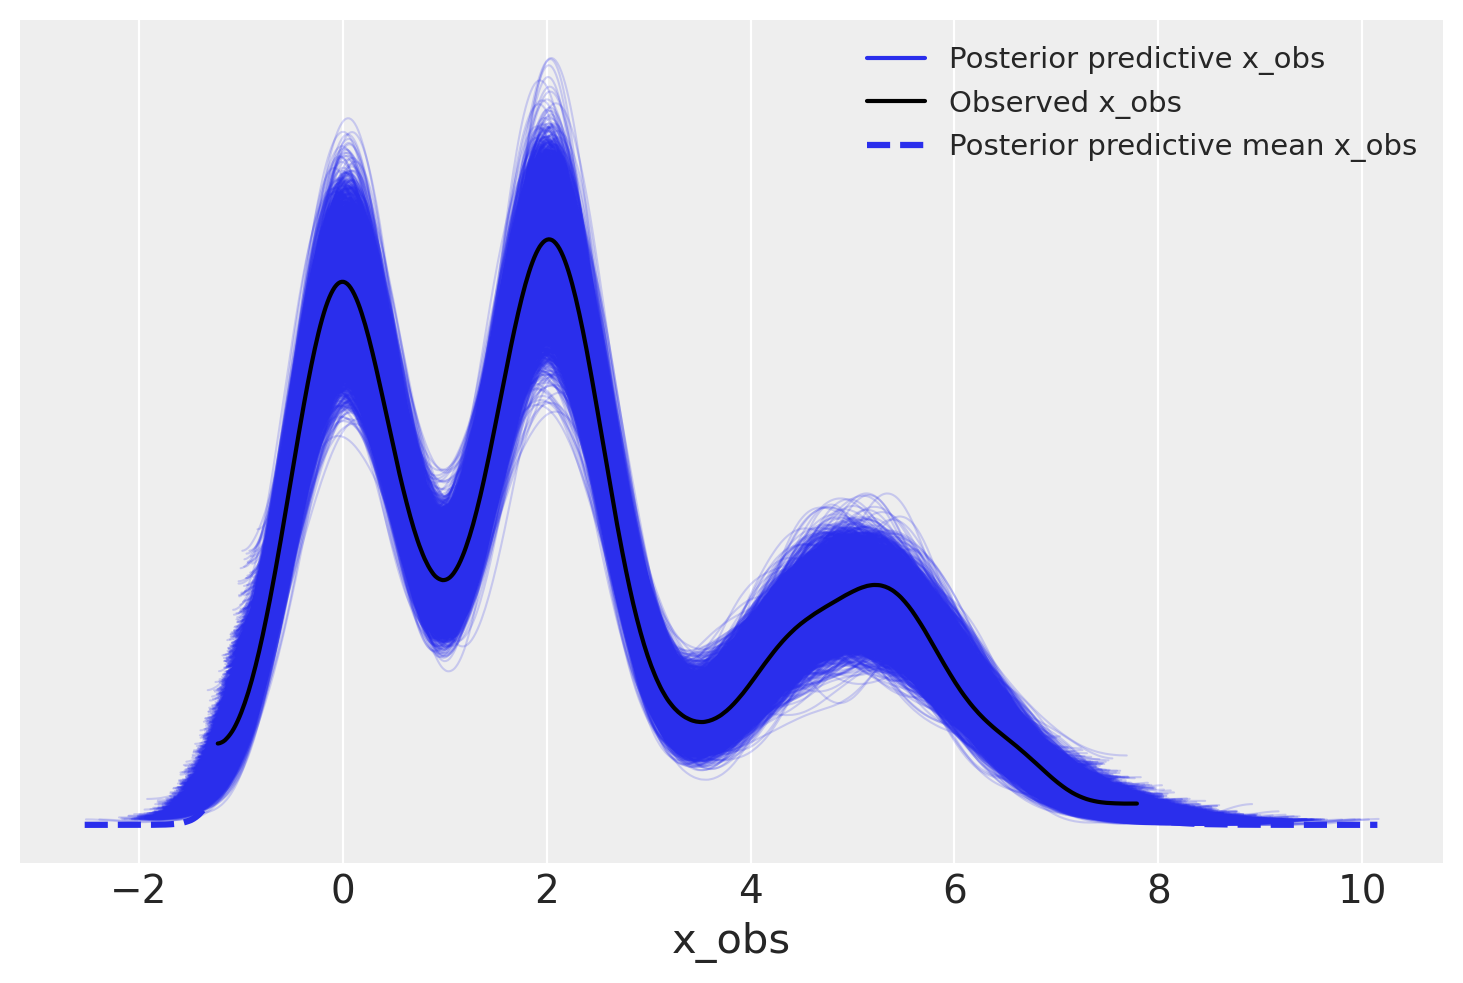

In [10]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_trace, model=model));

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Dec 16 2020

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.13.0

pymc3     : 3.10.0
matplotlib: 3.2.1
seaborn   : 0.10.0
numpy     : 1.17.5
arviz     : 0.10.0

Watermark: 2.1.0

